# IMPORTS

In [2]:
import os, sys, git, time, io, ntpath, tracemalloc, sqlite3, pandas as pd, numpy as np
from pandas.api.types import CategoricalDtype
import sklearn

os.chdir('../')
from scripts.log_processing.plotting import *

from scripts.log_processing.mazeAndPcsPlotter import *
import xml.etree.ElementTree as ET


# DO NOT IMPORT IN REAL SCRIPT:
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from os import path
import matplotlib.collections



%matplotlib widget

# DEFAULT PLOTTING THEMES

In [3]:
theme_default = theme (
    plot_title = element_text(size = 23),
    axis_title = element_text(size = 20),
    legend_title = element_text(size = 17),
    legend_text = element_text(size = 12),
    figure_size=(11, 8),
    axis_line=element_line(size=.7),

    # We are focusing on the ticks, make them long
    axis_ticks_length=10,
    axis_ticks_length_minor=5,
    axis_ticks_length_major=10,
    axis_text=element_text(size=20)
    
)
theme_set(theme_default)

# Functions

In [4]:
def adapt_array(arr):
    out = io.BytesIO()
    np.save(out, arr)
    out.seek(0)
    return sqlite3.Binary(out.read())

def convert_array(text):
    out = io.BytesIO(text)
    out.seek(0)
    return np.load(out)

# Converts np.array to TEXT when inserting
sqlite3.register_adapter(np.ndarray, adapt_array)

# Converts TEXT to np.array when selecting
sqlite3.register_converter("array", convert_array)

def lastEpisode(configs, sample_rate):
    num_episodes = configs['numEpisodes'].max() / configs['numStartingPositions'].max()
    last_episode = -sample_rate % num_episodes
    return last_episode

def getDataEpisodeAndSummaries(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET SUMMARIZED RUNTIME DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location)[0], configs, fields_to_add)

    # GET EPISODE DATA:
    runtimes_episode = None if skip_runtimes else augment_data(load_episode_runtimes(db, indices, location, episode), configs, fields_to_add)
            
    return summaries, runtimes_episode

def getReplayData(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET Replay DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location)[1], configs, fields_to_add)
            
    return summaries

def getFirstReplayData(db, configs, fields_to_add, episode, location, skip_runtimes = False, skip_summary = False):
    # GET INDICES TO BE RETRIEVED AND EXTRA DATA TO BE MERGED
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    # GET Replay DATA
    summaries = None if skip_summary else augment_data(load_summaries(db, indices, location)[2], configs, fields_to_add)
            
    return summaries

def getLearningTimes(db, configs, location, threshold, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    runtimes_all_episodes = load_all_runtimes_smaller_than_threshold(db, indices, location, threshold)  
    
    # learning rat defined as min episode with error < threshold
    learning_times = runtimes_all_episodes.loc[runtimes_all_episodes.groupby(['config', 'location', 'rat'])['episode'].idxmin()]
    
    return augment_data(learning_times, configs, fields_to_add)

def getTotalLearningTimes(db, configs, location, threshold, fields_to_add):
    indices = [np.uint16(c[1:]) for c in configs.index]  # config numbers
    
    runtimes_all_episodes = load_episode_runtimes2(db, indices, location)
    
    # learning rat defined as min episode with error < threshold
    learning_times = runtimes_all_episodes.loc[runtimes_all_episodes.groupby(['config', 'location', 'rat'])['episode'].idxmin()]
    
    return augment_data(learning_times, configs, fields_to_add)

def augment_data(data, configs, fields):
    return pd.merge(data, configs[ ['c_id'] + fields ], left_on='config', right_on='c_id', how='left')

def addCatigoricalData(data, field):
    catigorical_name = field + '_c'
    data[catigorical_name] = data[field].astype(CategoricalDtype(data[field].unique(), ordered=True))

def load_summaries(db, config_indices, location):
    indices_str = ','.join(map(str, config_indices))
    df = pd.read_sql_query("select config, location, rat, episode, errors "
                           "from rat_runtimes "
                           "where config in ({}) "
                           "AND location = {}"
                           .format(indices_str, np.uint8(location)), db)
    df2 = pd.read_sql_query("select config, rat, replay_matrix, mean, std, total_connection "
                           "from rat_replay_matrix "
                           "where config in ({}) "
                           .format(indices_str, np.uint8(location)), db)
    # df3 = pd.read_sql_query("select config, rat, first_replay_matrix  "
    #                        "from rat_first_replay_matrix "
    #                        "where config in ({}) "
                           # .format(indices_str, np.uint8(location)), db)
    # adjust data types to reduce memory size
    df.config = df.config.astype(np.uint16)
    df.location = df.location.astype(np.uint8)
    df.episode = df.episode.astype(np.uint16)
    df.errors = df.errors.astype(np.float32)
    return [df, df2]
    

# SET EXPERIMENT AND LOAD DATABASE

In [6]:
folder = 'experiments/replayF2021_experiments/logs/experiment14-largeScale/'
figure_folder = folder + 'figures/'
make_folder(figure_folder)

git_root = './'

layers_folder = 'experiments/pc_layers/'
layer_metrics_file = os.path.join(git_root, layers_folder + 'layer_metrics.csv')

maze_folder = 'experiments/mazes/'
maze_metrics_file = os.path.join(git_root, maze_folder + 'mazeMetrics.csv')

sample_rate = 1
db = sqlite3.connect(folder + 'experiment_results.sqlite',detect_types=sqlite3.PARSE_DECLTYPES)


In [7]:
min_layers = ['u04_40', 'u08_21', 'u12_14', 'u16_11', 'u20_09', 'u24_07', 'u28_06', 'u32_06', 'u36_06', 'u40_05', 'u44_05', 'u48_04', 'u52_04', 'u56_04']

# ADD COLUMNS TO CONFIGS
configs = load_config_file(folder)
configs['c_id'] = configs.index.map(lambda v : int(v[1:]))
configs['pc_files'] = configs.pc_files.map(os.path.normpath )
configs['pcs'] = configs.pc_files.map(lambda v : ntpath.basename(v)[0:-4])
configs['maze']= configs.mazeFile.map(lambda v : ntpath.basename(v)[0:-4])

# GET LAYER METRICS 
layer_metrics = pd.read_csv(layer_metrics_file)
layer_metrics['layer'] = layer_metrics.layer.map(lambda l : os.path.normpath(layers_folder + l) ) # normalize path and prepend location

maze_metrics = pd.read_csv(maze_metrics_file)

# f'CONFIG COLUMNS {configs.columns.values}', 'CONFIGS:', configs, 'LAYER METRICS:', layer_metrics
display(configs)
display(layer_metrics)

FileNotFoundError: [Errno 2] No such file or directory: 'experiments/replayF2021_experiments/logs/experiment14-largeScale/configs.csv'

# Experiment 12

# Sandbox for Replay Plots

In [6]:
# CHOOSE PARAMETERS
mazes = ["M100","M200"]
replay_budgets = [0,100,1000]


# CREATE FOLDERS FOR EXPERIMENT
folder_density_fixed_scale = os.path.join(figure_folder, 'replay_stuff/')
make_folder(folder_density_fixed_scale)


# GET CONFIGS RELEVANT TO EXPERIMENT
# keep mazes with varying number of obstacles only (all but M1 and M8), and only uniform layers
# experiment_configs = configs[configs.maze.isin(mazes) & configs.pcs.map(lambda v: v[0:3] == l) & (configs.traces == t)].copy()
experiment_configs = configs[configs.maze == "M100" ].copy()
# experiment_configs['num_obstacles'] = experiment_configs.maze.map(lambda m : int(m[1])*10)
# experiment_configs['scale'] = experiment_configs.pcs.map(lambda v : int(v[1:3]) )
# experiment_configs = pd.merge(experiment_configs.reset_index(), maze_metrics, left_on='mazeFile', right_on='maze', how='left').set_index('config')

# GET AND AUGMENT DATA
merge_fields = ['mazeFile', 'replay_budget']
episode = lastEpisode(experiment_configs, sample_rate)
location = -1
summaries, runtimes_last_episode = getDataEpisodeAndSummaries(db, experiment_configs, merge_fields, episode, location)

# GET REPLAY Matrix
merge_fields = ['maze', 'replay_budget', 'pcs']
summaries2 = getReplayData(db, experiment_configs, merge_fields, episode, location)
# summaries3 = getFirstReplayData(db, experiment_configs, merge_fields, episode, location)

addCatigoricalData(summaries,'replay_budget')
addCatigoricalData(summaries2,'replay_budget')
addCatigoricalData(runtimes_last_episode,'replay_budget')


# summaries['replay_budget_c'] = summaries['replay_budget'].astype(CategoricalDtype(summaries['replay_budget'].unique(), ordered=True))
# summaries2['replay_budget_c'] = summaries2['replay_budget'].astype(CategoricalDtype(summaries2['replay_budget'].unique(), ordered=True))


# Error Messures the number of steps / optimal path -1 (closer to zero better) 
threshold = 1
learning_times = getLearningTimes(db, experiment_configs, location, threshold, merge_fields)

learning_times['replay_budget_c'] = learning_times['replay_budget'].astype(CategoricalDtype(learning_times['replay_budget'].unique(), ordered=True))
# learning_times['replay_budget_c'] = pd.Categorical(learning_times['replay_budget'], categories=learning_times['replay_budget'].value_counts().index.tolist())

# GET AND AUGMENT DATA
merge_fields = ['mazeFile', 'replay_budget']
tl = getTotalLearningTimes(db, experiment_configs, location, threshold, merge_fields)

#print(tl['steps'])

# # DISPLAY
# fields = ['c_id', 'maze', 'num_obstacles', 'pcs', 'scale', 'number of cells']
# # display(experiment_configs['number of cells'].unique())
# # display(experiment_configs[fields])
# # display('SUMMARIES', summaries, 'RUN TIMES', runtimes_last_episode)
display(summaries2)
display(tl)
# display(experiment_configs)

,config,rat,replay_matrix,mean,std,total_connection,c_id,maze,replay_budget,pcs,replay_budget_c
0,0,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000058,0.004133,5.765476,0,M100,0,u16_15,0
1,0,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000063,0.004505,6.209163,0,M100,0,u16_15,0
2,0,2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000073,0.005133,7.258958,0,M100,0,u16_15,0
3,0,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000044,0.004334,4.348174,0,M100,0,u16_15,0
4,0,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000079,0.004405,7.815164,0,M100,0,u16_15,0
...,...,...,...,...,...,...,...,...,...,...,...
295,2,95,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000033,0.002995,3.297567,2,M100,1000,u16_15,1000
296,2,96,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000039,0.003773,3.864145,2,M100,1000,u16_15,1000
297,2,97,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000049,0.005668,4.871058,2,M100,1000,u16_15,1000
298,2,98,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000053,0.004785,5.245689,2,M100,1000,u16_15,1000


,config,location,rat,episode,steps,c_id,mazeFile,replay_budget
0,0,255,0,0,420.25,0,M100.xml,0
1,0,255,1,0,470.75,0,M100.xml,0
2,0,255,2,0,197.25,0,M100.xml,0
3,0,255,3,0,488.00,0,M100.xml,0
4,0,255,4,0,311.25,0,M100.xml,0
...,...,...,...,...,...,...,...,...
295,2,255,95,0,935.75,2,M100.xml,1000
296,2,255,96,0,372.25,2,M100.xml,1000
297,2,255,97,0,680.00,2,M100.xml,1000
298,2,255,98,0,712.00,2,M100.xml,1000


In [7]:

def getMazeAndPcsFolder():
    basepath = path.dirname('')
    rootpath = path.abspath(path.join(basepath, ".."))
    # maze_folder = path.abspath(path.join(rootpath,"logs/experiment12-replay/mazes/"))
    # pc_folder = path.abspath(path.join(rootpath,"logs/experiment12-replay/pc_layers/"))
    
    maze_folder = path.abspath(path.join(basepath,"experiments/replayF2021_experiments/logs/experiment12-replay/mazes/"))    
    pc_folder = path.abspath(path.join(basepath,"experiments/replayF2021_experiments/logs/experiment12-replay/pc_layers/"))
    
    return maze_folder, pc_folder


    

def plot_replay_matrix(data,maze_folder,pcs_folder):

    # Defines map for labels
    my_labels = {'sc' : 'Stongest Connection',
                 'gl' : 'Goal Location',
                 'sp' : 'Starting Locations',
                 'pc' : 'Place Cells'}

    # Plots the maze and Place Cells
    maze_file = os.path.join(maze_folder, data['maze']+'.xml')
    walls, feeders, start_positions = parse_maze(maze_file)
    pc_file = os.path.join(pcs_folder, data['pcs']+'.csv')
    cells = parse_all_cells(pc_file)
    fig, ax = plt.subplots()
    x = walls.loc[:, walls.columns[::2]]
    y = walls.loc[:, walls.columns[1::2]]
    for i in range(len(walls)):
        ax.plot(x.iloc[i,:], y.iloc[i,:], color='black', alpha=1.0)
    x = feeders['x']
    y = feeders['y']
    for i in range(len(x)):
        ax.plot(x,y,'rx', label=my_labels['gl'])
        my_labels['gl']= '_nolegend_'
    x = start_positions['x']
    y = start_positions['y']
    for i in range(len(x)):
        ax.plot(x,y,'bo', label=my_labels['sp'])
        my_labels['sp']= '_nolegend_'

    x = cells['x']
    y = cells['y']
    r = cells['r']
    xy = tuple(zip(x,y))
    coll = matplotlib.collections.EllipseCollection(r, r,
                                                    np.zeros_like(r),
                                                    offsets=xy, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'b',
                                                    alpha= 0)
    ax.add_collection(coll)

    # Gets Replay Matrix and Ignores Self Connected Place Cells
    cell_data = data['replay_matrix']
    np.fill_diagonal(cell_data,0.0)
    
    # Plots the Replay Matrix
    nonconnected_cells = []
    nonconnected_cells_r = []
    
    # Gets the index and value of max connection for each place cell
    max_index = np.argmax(cell_data, axis = 1)
    max_value = np.amax(cell_data,axis = 1)

    # Adds a line connection cells to their max connection
    for cell_index in range(len(cell_data)):
        # Plot a connection if it exsists
        if max_value[cell_index] != 0:
            # Connected to another Place Cell
            x=cells.values[cell_index][0]
            y=cells.values[cell_index][1]
            dx=cells.values[max_index[cell_index]][0] - x
            dy=cells.values[max_index[cell_index]][1] - y
            ax.arrow(x,y,dx,dy,width=.01, length_includes_head = True, label= my_labels['sc'],color = 'b',alpha=.5)
            my_labels['sc'] = '_nolegend_'

        # Has no connection
        else:
            nonconnected_cells.append((cells.values[cell_index][0], cells.values[cell_index][1]))
            nonconnected_cells_r.append(cells.values[cell_index][2])

   
    # # Adds red circles for non connected PCs
    # coll = matplotlib.collections.EllipseCollection(nonconnected_cells_r, nonconnected_cells_r,
    #                                                 np.zeros_like(nonconnected_cells_r),
    #                                                 offsets=nonconnected_cells, units='x',
    #                                                 transOffset=ax.transData,
    #                                                 color= 'r',
    #                                                 alpha= .5
    #                                                 )
    # ax.add_collection(coll)
    
    # Save Plot
    # TODO : fisx aspect ratio
    lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    name = 'LastReplayMatrix_Maze_'+ data['maze'] + '_Rat_'+ str(data['rat'])
    tit = fig.suptitle(name, fontsize=14)
    ax.set_aspect(1)
    plt.show()
    return fig
    # fig.savefig(replay_path+save_name + '.png',
    #             dpi=300,
    #             format='png',
    #             bbox_extra_artists=(lg,tit),
    #             bbox_inches = 'tight')
    #plt.close(fig)

def plot_first_replay_matrix(data,maze_folder,pcs_folder):

    # Defines map for labels
    my_labels = {'sc' : 'Stongest Connection',
                 'gl' : 'Goal Location',
                 'sp' : 'Starting Locations',
                 'pc' : 'Place Cells'}

    # Plots the maze and Place Cells
    maze_file = os.path.join(maze_folder, data['maze']+'.xml')
    walls, feeders, start_positions = parse_maze(maze_file)
    pc_file = os.path.join(pcs_folder, data['pcs']+'.csv')
    cells = parse_all_cells(pc_file)
    fig, ax = plt.subplots()
    x = walls.loc[:, walls.columns[::2]]
    y = walls.loc[:, walls.columns[1::2]]
    for i in range(len(walls)):
        ax.plot(x.iloc[i,:], y.iloc[i,:], color='black', alpha=1.0)
    x = feeders['x']
    y = feeders['y']
    for i in range(len(x)):
        ax.plot(x,y,'rx', label=my_labels['gl'])
        my_labels['gl']= '_nolegend_'
    x = start_positions['x']
    y = start_positions['y']
    for i in range(len(x)):
        ax.plot(x,y,'bo', label=my_labels['sp'])
        my_labels['sp']= '_nolegend_'

    x = cells['x']
    y = cells['y']
    r = cells['r']
    xy = tuple(zip(x,y))
    coll = matplotlib.collections.EllipseCollection(r, r,
                                                    np.zeros_like(r),
                                                    offsets=xy, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'b',
                                                    alpha= 0)
    ax.add_collection(coll)

    # Gets Replay Matrix and Ignores Self Connected Place Cells
    cell_data = data['first_replay_matrix']
    np.fill_diagonal(cell_data,0.0)
    
    # Plots the Replay Matrix
    nonconnected_cells = []
    nonconnected_cells_r = []
    
    # Gets the index and value of max connection for each place cell
    max_index = np.argmax(cell_data, axis = 1)
    max_value = np.amax(cell_data,axis = 1)

    # Adds a line connection cells to their max connection
    for cell_index in range(len(cell_data)):
        # Plot a connection if it exsists
        if max_value[cell_index] != 0:
            # Connected to another Place Cell
            x=cells.values[cell_index][0]
            y=cells.values[cell_index][1]
            dx=cells.values[max_index[cell_index]][0] - x
            dy=cells.values[max_index[cell_index]][1] - y
            ax.arrow(x,y,dx,dy,width=.01, length_includes_head = True, label= my_labels['sc'],color = 'b',alpha=.5)
            my_labels['sc'] = '_nolegend_'

        # Has no connection
        else:
            nonconnected_cells.append((cells.values[cell_index][0], cells.values[cell_index][1]))
            nonconnected_cells_r.append(cells.values[cell_index][2])

   
    # Adds red circles for non connected PCs
    coll = matplotlib.collections.EllipseCollection(nonconnected_cells_r, nonconnected_cells_r,
                                                    np.zeros_like(nonconnected_cells_r),
                                                    offsets=nonconnected_cells, units='x',
                                                    transOffset=ax.transData,
                                                    color= 'r',
                                                    alpha= .5
                                                    )
    ax.add_collection(coll)
    
    # Save Plot
    # TODO : fisx aspect ratio
    lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    name = 'FirstReplayMatrix_Maze_'+ data['maze'] + '_Rat_'+ str(data['rat'])
    tit = fig.suptitle(name, fontsize=14)
    ax.set_aspect(1)
    plt.show()
    return fig


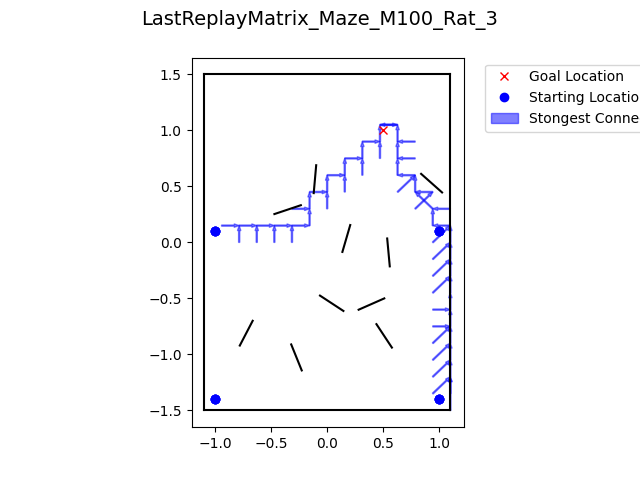

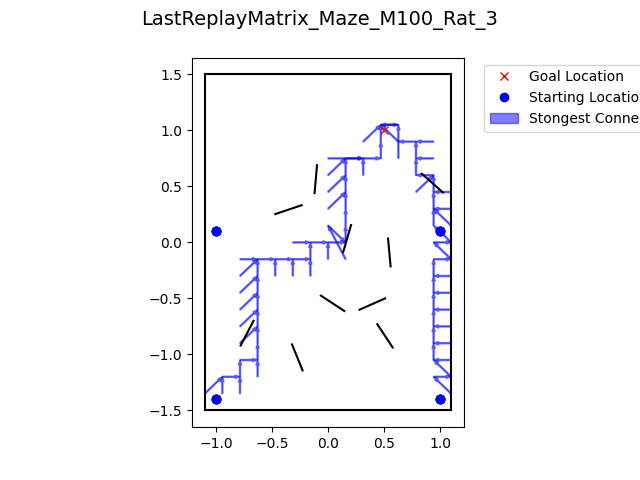

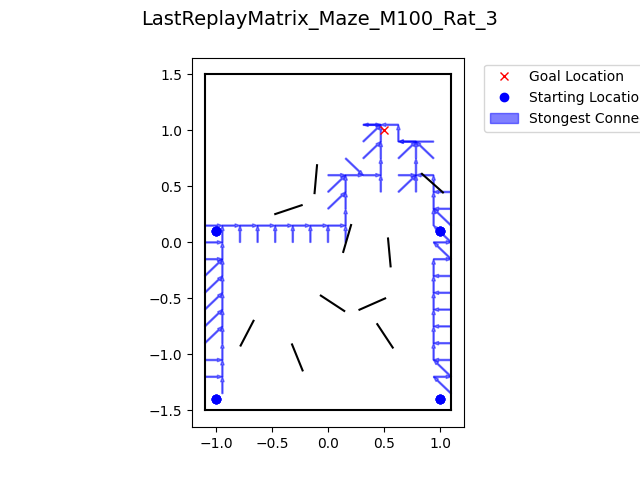

In [17]:
test = summaries2[summaries2['rat']==3]
summaries2['mean']
maze_folder, pcs_folder = getMazeAndPcsFolder()
for index, row in test.iterrows():
    fig = plot_replay_matrix(row,maze_folder,pcs_folder)
    
fig.savefig("LastReplayMatrix.pdf",bbox_inches='tight')

In [18]:
test = summaries3[summaries3['rat']==3]
maze_folder, pcs_folder = getMazeAndPcsFolder()
for index, row in test.iterrows():
    fig = plot_first_replay_matrix(row,maze_folder,pcs_folder)
    
fig.savefig("FirstReplayMatrix.pdf",bbox_inches='tight')

NameError: name 'summaries3' is not defined

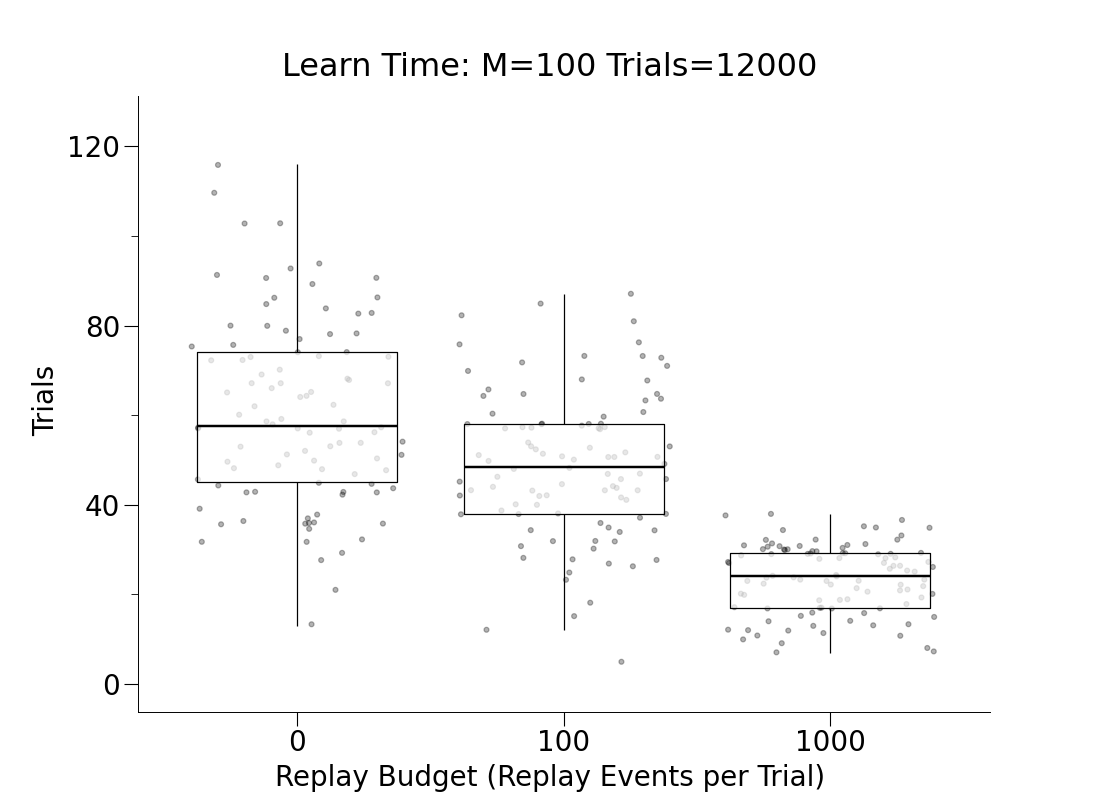

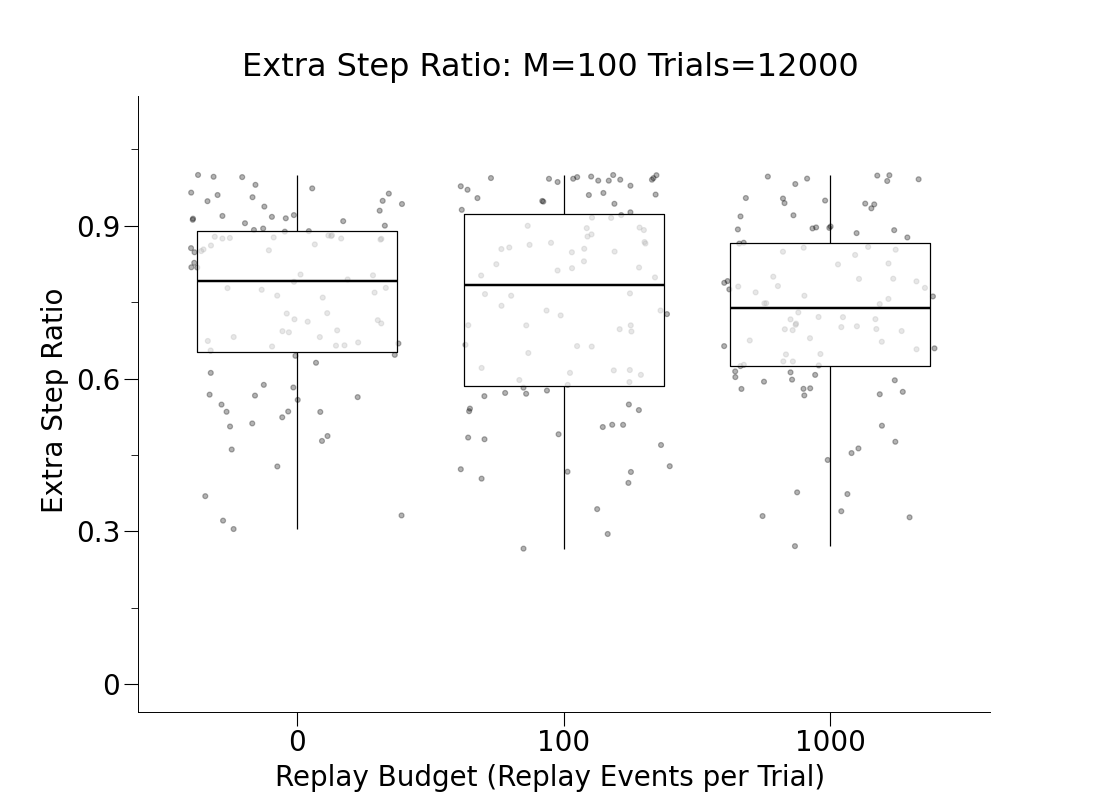

In [8]:
def plot_box_plot(data, x_column, y_column, x_title, y_title, plot_title, ylim, box_colors):
    # print(data)
    p0 = ggplot(data, aes(x_column, y_column ))
    p0 += geom_jitter(alpha=0.3)
    p0 += geom_boxplot(alpha=0.7, notch=False, outlier_alpha=0, color = box_colors )
    p0 += xlab(x_title)
    p0 += ylab(y_title)
    p0 += ggtitle(plot_title)
    p0 += labs(x=x_title, y=y_title, title=plot_title)
    # p0 += theme(axis_text_x=element_text(rotation=45, hjust=1))
    p0 += coord_cartesian(ylim=ylim)              
    return p0


def plot_time_series(data, x_column, y_column, fill_column, x_title, y_title, legend_title, plot_title, xlim, ylim):
    p0 = ggplot(data, aes(x_column, y_column, color=fill_column))
    
    p0 += geom_smooth(method='mavg')
    p0 += labs(x=x_title, y=y_title, color=legend_title, title=plot_title, caption='smt')
    # p0 += coord_cartesian(ylim=ylim, xlim=xlim)
    p0 += scale_color_discrete()
    return p0

# TODO: add plot for total connection metric
fig1 = plot_box_plot(learning_times, 'replay_budget_c', 'episode', 'Replay Budget (Replay Events per Trial)', 'Trials', 'Learn Time: M=100 Trials=12000', [0, 125], 'black' )

# fig2 = plot_time_series(learning_times, 'episode', 'steps', 'replay_budget_c', 'Episodes', 'Episodes', 'Replay Budget', 'Extra Episodes', [0,250], [0, 5] )

# fig3 = plot_box_plot(summaries2, 'replay_budget_c', 'mean', 'Replay Budget', 'Average Connection', 'M100',[0, 200], 'black')

# fig4 = plot_box_plot(summaries2, 'replay_budget_c', 'std', 'Replay Budget', 'STD Connection', 'M100',[0, 200], 'black')

fig5 = plot_box_plot(learning_times, 'replay_budget_c', 'steps', 'Replay Budget (Replay Events per Trial)', 'Extra Step Ratio', 'Extra Step Ratio: M=100 Trials=12000', [0, 1.1], 'black' )

# fig6 = plot_box_plot(test, 'replay_budget_c', 'total_connection', 'Replay Budget', 'Total Connection', 'M100',[0, 200], 'black')

fig1 = fig1.draw()
fig5 = fig5.draw()
# fig3.draw()
# fig4.draw()
# fig6.draw()
# fig2.draw()
fig1.savefig("LearningTime.pdf")
fig5.savefig("OptimalityRaio.pdf")

In [ ]:
fig3 = plot_box_plot(summaries, 'replay_budget_c', 'mean', 'Replay Budget', 'Average Connection', 'M100',[0, 200], 'black')

# Sandbox for SQL

In [83]:
import csv
def getLastMatrix(file, num_cells = 315):
    p = list(csv.reader(file, delimiter='\n'))
    start_index = len(p)-num_cells
    last_matrix = p[start_index:]
    print(len(last_matrix))

    for i in range(len(last_matrix)):
        last_matrix[i] = [r.strip() for r in last_matrix[i][0].split(',')]
        last_matrix[i] = last_matrix[i][:num_cells]
        last_matrix[i] = [float(r) for r in last_matrix[i]]
    return np.array(last_matrix,dtype=np.float128)
    
num_cells = 315
file_path = 'experiments/replayF2021_experiments/logs/experiment12-replay/configs/c0/r{}-Replay_Matrix.csv'
with open(file_path.format(0), 'rt') as file:
    getLastMatrix(file)
        
                

315


In [55]:
matrix

[[['0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
   ' 0.0',
